In [1]:
%matplotlib inline
import numpy as np
from skyfield.api import load, Topos
from scipy.optimize import newton
from matplotlib import pyplot as plt
planets = load('de423.bsp')

In [2]:
class plutino:
    """
    generate plutinos
    units: au, radius
    
    """
    def __init__(self, size = 1000, mjd = 57023, e_c = 0.175, e_sigma = 0.06, i_sigma = 12,\
                 amp_c = 75, amp_max = 155, amp_min = 0):
        self.size = size
        self.mjd = mjd
        self.lambda_N = 5.043
        self.a = self.gen_a()
        self.e = self.gen_e(e_c, e_sigma)
        self.i = self.gen_i(i_sigma)
        self.amp = self.gen_amp(amp_c, amp_max, amp_min)
        self.phi = self.gen_phi(self.amp)
        self.M = self.gen_M()
        self.node = self.gen_node()
        self.arg = self.gen_arg(self.phi, self.M, self.node, self.lambda_N)
        self.H = self.gen_H()
        cut = (self.e > 0) * (~np.isnan(self.i))
        self.a = self.a[cut]
        self.e = self.e[cut]
        self.i = self.i[cut]
        self.amp = self.amp[cut]
        self.phi = self.phi[cut]
        self.M = self.M[cut]
        self.node = self.node[cut]
        self.arg = self.arg[cut]
        self.H = self.H[cut]
        X, Y, Z, r = zip(*map(self.kep_to_xyz, self.a, self.e, self.i,\
                                                  self.arg, self.node, self.M)) # r**2 = X**2 + Y**2 + Z**2
        self.X = np.array(X)
        self.Y = np.array(Y)
        self.Z = np.array(Z)
        self.r = np.array(r)
        self.xyz_to_equa(self.X, self.Y, self.Z)
        self.H_to_mag()
    
    def gen_a(self):
        return 39.45 + np.random.random(self.size) * 0.4 - 0.2
        
    def gen_e(self, e_c, e_sigma):
        return np.random.normal(loc=e_c, scale=e_sigma, size = self.size)
        
    def gen_i(self, i_sigma):
        return np.arcsin(np.random.rayleigh(scale = i_sigma * np.pi/180., size = self.size))
        
    def gen_amp(self, amp_c, amp_max, amp_min):
        return np.random.triangular(amp_min, amp_c, amp_max, size = self.size) * np.pi / 180.
    
    def gen_phi(self, amp):
        return np.pi + amp * np.sin(2*np.pi*np.random.random(self.size)) 
        
    def gen_M(self):
        return 4*np.pi*np.random.random(self.size)
        
    def gen_node(self):
        return 2*np.pi*np.random.random(self.size) % (2*np.pi)
        
    def gen_arg(self, phi, M, node, lambda_N):
        return (0.5*phi - 1.5*M - node + lambda_N) % (2*np.pi)
        
    def gen_H(self):
        alpha = 0.9
        h0 = 0
        h1 = 10
        h0s10 = 10**(alpha*h0)
        h1s10 = 10**(alpha*h1)
        return np.log10(np.random.random(self.size)*(h1s10-h0s10) + h0s10) / alpha
        
    def kep_to_xyz(self, a, e, i, arg, node, M):
        # compute eccentric anomaly
        f = lambda E, M, e: E - e * np.sin(E) - M
        E0 = M
        E = newton(f, E0, args=(M, e))
        # compute true anomaly
        v = 2 * np.arctan2((1 + e)**0.5*np.sin(E/2.), (1 - e)**0.5*np.cos(E/2.))
        # compute the radius
        r = a * (1 - e*np.cos(E))
        # compute X,Y,Z
        X = r * (np.cos(node) * np.cos(arg + v) - np.sin(node) * np.sin(arg + v) * np.cos(i))
        Y = r * (np.sin(node) * np.cos(arg + v) + np.cos(node) * np.sin(arg + v) * np.cos(i))
        Z = r * (np.sin(i) * np.sin(arg + v))
        return X, Y, Z, r
        
    def xyz_to_equa(self, X0, Y0, Z0):
        earth = planets['earth']
        ts = load.timescale()
        t = ts.tai(jd=self.mjd+2400000.500428) #37 leap seconds
        epsilon =  23.43694 * np.pi/180.
        x_earth, y_earth, z_earth = earth.at(t).position.au
        self.earth_dis = (x_earth**2 + y_earth**2 + z_earth**2)**0.5
        X = X0 - x_earth
        Y = Y0 * np.cos(epsilon) + Z0 * np.sin(epsilon)  - y_earth
        Z = Y0 * np.sin(epsilon) - Z0 * np.cos(epsilon) - z_earth
        self.delta = (X**2 + Y**2+ Z**2)**0.5
        self.dec = np.arcsin(Z/(X**2+Y**2+Z**2)**0.5)
        self.ra = np.arctan2(Y, X) % (2*np.pi)
        
    def H_to_mag(self):
        phase = np.arccos((self.r**2 + self.delta**2 - self.earth_dis**2) / (2 * self.r * self.delta))
        phase_integral = 2/3. * ((1-phase/np.pi)*np.cos(phase) + 1/np.pi*np.sin(phase))
        self.mag = self.H + 2.5 * np.log10((self.r**2 * self.delta**2) / phase_integral)
        
        

In [3]:
p = plutino(size = 2000, e_c = 0.3, e_sigma = 0.01, amp_c = 1, amp_max = 2, amp_min = 0, i_sigma=12)

(array([103.,  97.,  92.,  95.,  88., 103.,  95., 113.,  85., 114., 108.,
         92., 100., 108.,  97., 107.,  99., 109., 111.,  84.]),
 array([39.25016304, 39.27014626, 39.29012948, 39.3101127 , 39.33009592,
        39.35007914, 39.37006236, 39.39004558, 39.4100288 , 39.43001202,
        39.44999524, 39.46997846, 39.48996168, 39.5099449 , 39.52992812,
        39.54991134, 39.56989456, 39.58987778, 39.609861  , 39.62984422,
        39.64982744]),
 <a list of 20 Patch objects>)

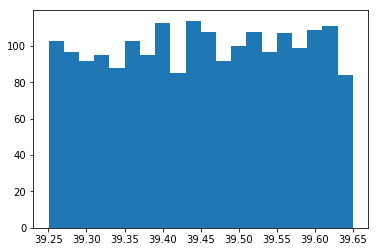

In [4]:
plt.hist(p.a, bins = 20)

(array([  4.,   2.,  22.,  37.,  55., 106., 163., 220., 254., 254., 242.,
        220., 157., 123.,  74.,  40.,  18.,   6.,   2.,   1.]),
 array([0.26886365, 0.27215664, 0.27544963, 0.27874262, 0.28203561,
        0.2853286 , 0.28862159, 0.29191458, 0.29520757, 0.29850056,
        0.30179355, 0.30508654, 0.30837953, 0.31167252, 0.31496551,
        0.3182585 , 0.32155149, 0.32484448, 0.32813747, 0.33143046,
        0.33472345]),
 <a list of 20 Patch objects>)

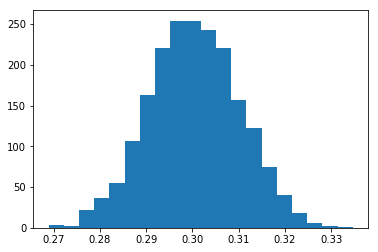

In [5]:
plt.hist(p.e, bins = 20)

(array([ 62., 154., 274., 259., 254., 270., 178., 190., 123.,  81.,  69.,
         43.,  15.,  16.,   4.,   4.,   3.,   0.,   0.,   1.]),
 array([ 0.208053  ,  3.16776272,  6.12747244,  9.08718215, 12.04689187,
        15.00660159, 17.9663113 , 20.92602102, 23.88573074, 26.84544045,
        29.80515017, 32.76485989, 35.7245696 , 38.68427932, 41.64398904,
        44.60369875, 47.56340847, 50.52311819, 53.4828279 , 56.44253762,
        59.40224734]),
 <a list of 20 Patch objects>)

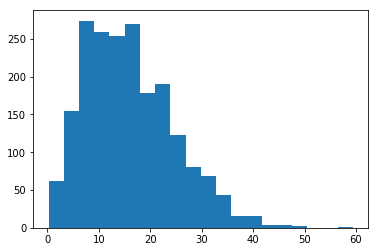

In [6]:
plt.hist(p.i*180/np.pi, bins = 20)

(array([1.000e+00, 0.000e+00, 3.000e+00, 5.000e+00, 1.600e+01, 3.400e+01,
        8.200e+01, 2.300e+02, 4.970e+02, 1.132e+03]),
 array([5.80322819, 6.22289755, 6.6425669 , 7.06223625, 7.48190561,
        7.90157496, 8.32124431, 8.74091367, 9.16058302, 9.58025237,
        9.99992173]),
 <a list of 10 Patch objects>)

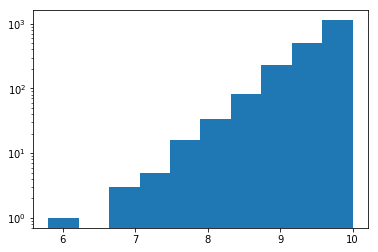

In [7]:
plt.yscale('log', bins = 20)
plt.hist(p.H)

(array([  4.,  10.,  45., 121., 271., 240., 279., 340., 377., 313.]),
 array([22.50882969, 23.02004795, 23.53126621, 24.04248446, 24.55370272,
        25.06492098, 25.57613924, 26.0873575 , 26.59857576, 27.10979402,
        27.62101227]),
 <a list of 10 Patch objects>)

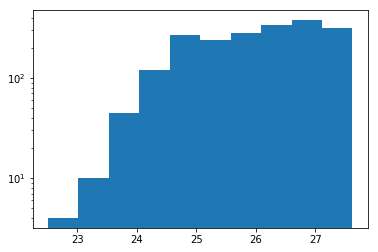

In [8]:
plt.yscale('log', bins = 20)
plt.hist(p.mag)

(array([102., 102.,  94.,  96.,  86., 104.,  91., 119., 129., 108.,  93.,
         90., 106.,  77., 105., 109.,  84., 100., 110.,  95.]),
 array([1.06376479e-02, 6.38021394e-01, 1.26540514e+00, 1.89278889e+00,
        2.52017263e+00, 3.14755638e+00, 3.77494012e+00, 4.40232387e+00,
        5.02970761e+00, 5.65709136e+00, 6.28447511e+00, 6.91185885e+00,
        7.53924260e+00, 8.16662634e+00, 8.79401009e+00, 9.42139383e+00,
        1.00487776e+01, 1.06761613e+01, 1.13035451e+01, 1.19309288e+01,
        1.25583126e+01]),
 <a list of 20 Patch objects>)

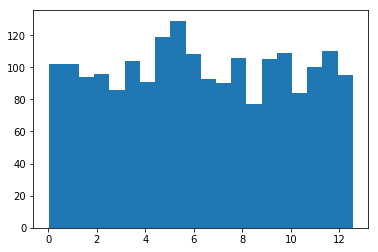

In [9]:
plt.hist(p.M, bins = 20)

(array([113.,  85., 108.,  95., 113., 102., 104., 111., 104., 101.,  99.,
         97.,  82.,  93.,  82., 119., 110.,  77., 114.,  91.]),
 array([1.24957444e-03, 3.15045217e-01, 6.28840860e-01, 9.42636502e-01,
        1.25643215e+00, 1.57022779e+00, 1.88402343e+00, 2.19781907e+00,
        2.51161472e+00, 2.82541036e+00, 3.13920600e+00, 3.45300164e+00,
        3.76679729e+00, 4.08059293e+00, 4.39438857e+00, 4.70818421e+00,
        5.02197986e+00, 5.33577550e+00, 5.64957114e+00, 5.96336679e+00,
        6.27716243e+00]),
 <a list of 20 Patch objects>)

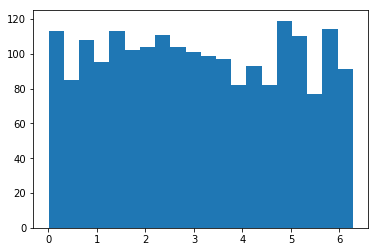

In [10]:
plt.hist(p.arg, bins = 20)

(array([105., 101.,  98.,  96.,  99., 101.,  95.,  94., 107.,  95., 111.,
        105., 105., 102., 118.,  90.,  92.,  90.,  95., 101.]),
 array([6.13391866e-03, 3.19982613e-01, 6.33831308e-01, 9.47680003e-01,
        1.26152870e+00, 1.57537739e+00, 1.88922609e+00, 2.20307478e+00,
        2.51692348e+00, 2.83077217e+00, 3.14462087e+00, 3.45846956e+00,
        3.77231825e+00, 4.08616695e+00, 4.40001564e+00, 4.71386434e+00,
        5.02771303e+00, 5.34156173e+00, 5.65541042e+00, 5.96925912e+00,
        6.28310781e+00]),
 <a list of 20 Patch objects>)

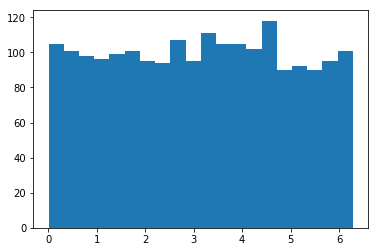

In [11]:
plt.hist(p.node, bins = 20)

(array([106.,  72.,  87., 122., 102., 113.,  92.,  79., 105., 104.,  93.,
         88.,  91., 103., 119., 115.,  94., 109., 112.,  94.]),
 array([3.86633354e-03, 3.17638693e-01, 6.31411052e-01, 9.45183411e-01,
        1.25895577e+00, 1.57272813e+00, 1.88650049e+00, 2.20027285e+00,
        2.51404521e+00, 2.82781757e+00, 3.14158992e+00, 3.45536228e+00,
        3.76913464e+00, 4.08290700e+00, 4.39667936e+00, 4.71045172e+00,
        5.02422408e+00, 5.33799644e+00, 5.65176880e+00, 5.96554116e+00,
        6.27931352e+00]),
 <a list of 20 Patch objects>)

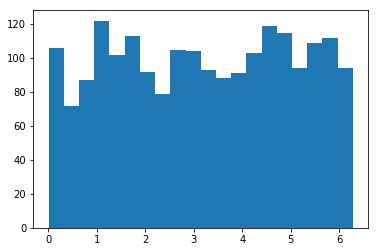

In [12]:
plt.hist((p.arg+p.node) % (2*np.pi), bins = 20)

(array([  4.,  18.,  31.,  65., 102., 112., 149., 170., 171., 162., 166.,
        171., 168., 137., 122., 100.,  77.,  41.,  21.,  13.]),
 array([3.1072828 , 3.11064946, 3.11401612, 3.11738278, 3.12074945,
        3.12411611, 3.12748277, 3.13084943, 3.1342161 , 3.13758276,
        3.14094942, 3.14431608, 3.14768275, 3.15104941, 3.15441607,
        3.15778273, 3.1611494 , 3.16451606, 3.16788272, 3.17124938,
        3.17461604]),
 <a list of 20 Patch objects>)

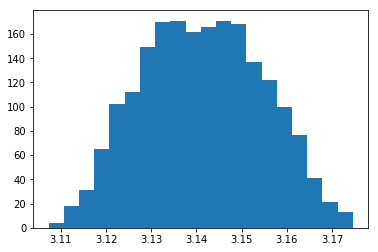

In [13]:
plt.hist(p.phi, bins = 20)

In [14]:
def kep_to_xyz(a, e, i, arg, node, M):
    # compute eccentric anomaly
    f = lambda E, M, e: E - e * np.sin(E) - M
    E0 = M
    E = newton(f, E0, args=(M, e))
    # compute true anomaly
    v = 2 * np.arctan2((1 + e)**0.5*np.sin(E/2.), (1 - e)**0.5*np.cos(E/2.))
    # compute the radius
    r = a * (1 - e*np.cos(E))
    # compute X,Y,Z
    X = r * (np.cos(node) * np.cos(arg + v) - np.sin(node) * np.sin(arg + v) * np.cos(i))
    Y = r * (np.sin(node) * np.cos(arg + v) + np.cos(node) * np.sin(arg + v) * np.cos(i))
    Z = r * (np.sin(i) * np.sin(arg + v))
    return X, Y, Z

In [15]:
xn, yn, zn = zip(*map(kep_to_xyz, 30+np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.arange(0, 6.28, 0.00628)))
x45, y45, z45 = zip(*map(kep_to_xyz, 45+np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.arange(0, 6.28, 0.00628)))

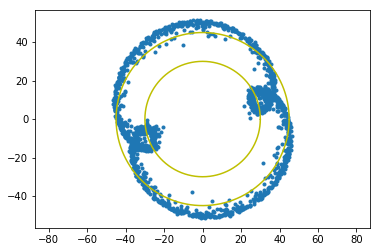

In [16]:
plt.axis('equal')
plt.scatter(p.X,p.Y, marker = '.')
plt.plot(xn, yn, 'y')
plt.plot(x45, y45, 'y')

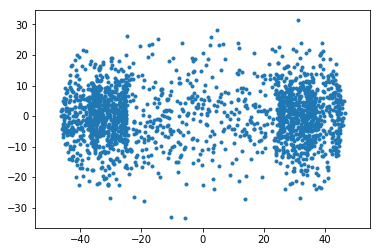

In [17]:
plt.axis('equal')
plt.scatter(p.X,p.Z, marker = '.')

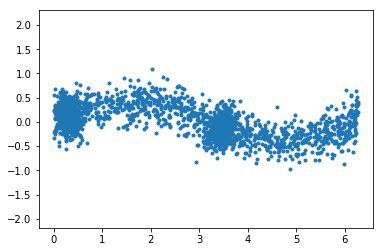

In [18]:
plt.axis('equal')
plt.scatter(p.ra,p.dec, marker = '.')